In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20dsazx GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

In [3]:
train = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")
test_data = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv")
sample_sub = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv")

# **Data Understanding**

In [4]:
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [5]:
test_data.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


In [6]:
sample_sub.head()

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,0
1,8eaeaf13213eeb16ad879a2a2591bbe5,0
2,dce649b733c153ba5363a0413cac988f,0
3,8a46df0bb997269d6834f9437a4b0a77,0
4,d11d3091e22f1cf3cb865598de197599,0


In [7]:
train.shape

(900000, 11)

In [8]:
test_data.shape

(478033, 10)

In [9]:
train.sample(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
58500,0295022405ac437e5d1fd63ac62255d0,25752041,0b6ed8ee5975d25e79edbbdef5a4703a,0,I was given an Advance Readers Copy for an hon...,Thu Jan 19 15:39:40 -0800 2017,Mon Feb 06 03:36:17 -0800 2017,NaN,Wed Jan 25 00:00:00 -0800 2017,1,1
396446,e32a1e02652237ed422a2fd5035dd4f0,34470279,cd78b810d75363e6145ca4d67521023e,0,"""There are no rules when it comes to life and ...",Wed Apr 12 08:08:31 -0700 2017,Thu Apr 20 07:23:23 -0700 2017,Fri Apr 14 00:00:00 -0700 2017,Wed Apr 12 00:00:00 -0700 2017,5,2
15163,c66ec6d215a6d6a6ced2398ebf56ce70,6088255,dd7a5b3abde508bab957474cace16b60,5,What an emotional journey. This book was so mu...,Mon Jul 02 22:27:03 -0700 2012,Thu Nov 01 22:54:39 -0700 2012,NaN,NaN,1,0
818404,4f6d4eb63610dc6f8acc11794dd3c086,6334,f538b626c738efb506bfc2c0d445a472,4,Well that was fucking depressing.,Sun Dec 21 20:04:48 -0800 2014,Wed Dec 24 01:04:59 -0800 2014,Wed Dec 24 06:58:46 -0800 2014,Sun Dec 21 00:00:00 -0800 2014,2,0
432451,32b61746df2ad179a61d924f609b0d86,32200595,67647f31119335d249a5f3098ec52c73,5,I cannot believe how many times I wanted to pu...,Thu Aug 18 17:31:53 -0700 2016,Tue May 16 15:23:12 -0700 2017,Wed May 17 00:00:00 -0700 2017,Mon May 15 00:00:00 -0700 2017,0,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478033 entries, 0 to 478032
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       478033 non-null  object
 1   book_id       478033 non-null  int64 
 2   review_id     478033 non-null  object
 3   review_text   478033 non-null  object
 4   date_added    478033 non-null  object
 5   date_updated  478033 non-null  object
 6   read_at       435555 non-null  object
 7   started_at    334989 non-null  object
 8   n_votes       478033 non-null  int64 
 9   n_comments    478033 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 36.5+ MB


In [12]:
train.isnull().mean()*100

user_id          0.000000
book_id          0.000000
review_id        0.000000
rating           0.000000
review_text      0.000000
date_added       0.000000
date_updated     0.000000
read_at         10.196222
started_at      30.477444
n_votes          0.000000
n_comments       0.000000
dtype: float64

In [13]:
test_data.isnull().mean()*100

user_id          0.000000
book_id          0.000000
review_id        0.000000
review_text      0.000000
date_added       0.000000
date_updated     0.000000
read_at          8.885997
started_at      29.923457
n_votes          0.000000
n_comments       0.000000
dtype: float64

In [14]:
train.duplicated().sum()

0

In [15]:
test_data.duplicated().sum()

0

# **Data Cleaning**

In [16]:
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [17]:
train = train[["review_text", "rating"]]
test = test_data[["review_text"]]

In [18]:
train["rating"].unique()

array([5, 3, 0, 4, 2, 1])

In [19]:
train0 = train[train['rating']==0]
train1 = train[train['rating']==1]
train2 = train[train['rating']==2]
train3 = train[train['rating']==3]
train4 = train[train['rating']==4]
train5 = train[train['rating']==5]

In [20]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape, train5.shape

((30988, 2), (28718, 2), (72627, 2), (188972, 2), (313688, 2), (265007, 2))

In [21]:
train0 = train0[:int(train0.shape[0]/1000)]
train1 = train1[:int(train1.shape[0]/1000)]
train2 = train2[:int(train2.shape[0]/1000)]
train3 = train3[:int(train3.shape[0]/1000)]
train4 = train4[:int(train4.shape[0]/1000)]
train5 = train5[:int(train5.shape[0]/1000)]

In [22]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape, train5.shape

((30, 2), (28, 2), (72, 2), (188, 2), (313, 2), (265, 2))

In [23]:
train = pd.concat([train0,train1,train2,train3,train4,train5],axis=0)

In [24]:
train.shape

(896, 2)

In [25]:
train.sample(10)

,review_text,rating
433,"4.5 stars! Maverick. Yes, please! \n This nove...",4
478,4 1/2 stars! A very grown-up sequel to the fir...,4
316,4.5 stars!! \n This was my first book by Monic...,5
225,Slip of the Tongue is absolutely enthralling. ...,5
162,3.5 Stars \n If you like lots of high school d...,4
914,Not worth anywhere near $2. I say it should've...,2
176,"""All she sees is what's right in front of her....",4
1024,It took a little while for this book to hit it...,0
720,The book has been around a while so I was fami...,0
83,"""You're the queen. I'm just a commoner. \n GAH...",5


In [26]:
train.head()

,review_text,rating
3,Recommended reading to understand what is goin...,0
7,Numerous people in publishing have told me thi...,0
13,Recommended by David Risher,0
54,"Well if Melanie says its her BBE, I gotta chec...",0
58,"If steve recommends it, it must be good!",0


In [27]:
train["review_text"][0]

'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. (view spoiler)[Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would happen if our SETI stations received a message - if we found someone was out there - and the person monitoring and answering the signal o

In [28]:
train["review_text"][2]

'A fun, fast paced science fiction thriller. I read it in 2 nights and couldn\'t put it down. The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world. And in this book, someone invents a way to switch between these worlds. This was nicely alluded to/foreshadowed in this quote: \n "I think about all the choices we\'ve made that created this moment. Us sitting here together at this beautiful table. Then I think of all the possible events that could have stopped this moment from ever happening, and it all feels, I don\'t know..." "What?" "So fragile." Now he becomes thoughtful for a moment. He says finally, "It\'s terrifying when you consider that every thought we have, every choice we could possibly make, branches into a new world." \n (view spoiler)[This book can\'t be discussed without spoilers. It is a book abou

In [29]:
train["review_text"][1]

'Recommended by Don Katz. Avail for free in December: http://www.audible.com/mt/ellison2?so...'

In [30]:
train["rating"].value_counts()

4    313
5    265
3    188
2     72
0     30
1     28
Name: rating, dtype: int64

# **Exploratory Data Analysis**

In [31]:
train.head()

,review_text,rating
3,Recommended reading to understand what is goin...,0
7,Numerous people in publishing have told me thi...,0
13,Recommended by David Risher,0
54,"Well if Melanie says its her BBE, I gotta chec...",0
58,"If steve recommends it, it must be good!",0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rating', ylabel='count'>

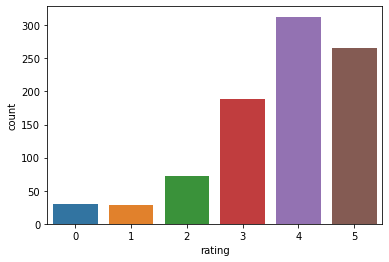

In [32]:
sns.countplot(train["rating"])

<AxesSubplot:ylabel='rating'>

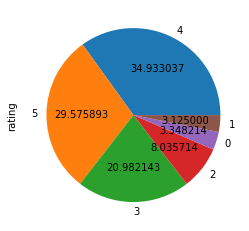

In [33]:
train["rating"].value_counts().plot(kind="pie", autopct="%2f")

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
# Number of Characters in a line of Text
train["number_of_char"] = train["review_text"].apply(len)

In [36]:
train["review_text"].apply(lambda x:nltk.word_tokenize(x))

3      [Recommended, reading, to, understand, what, i...
7      [Numerous, people, in, publishing, have, told,...
13                      [Recommended, by, David, Risher]
54     [Well, if, Melanie, says, its, her, BBE, ,, I,...
58     [If, steve, recommends, it, ,, it, must, be, g...
                             ...                        
577    [REALKaty, Evans, FIVE, HOT, AND, EMOTIONAL, S...
582    [Come, to, Me, Quietly, is, the, first, book, ...
584    [Breathtaking, and, ultimately, beautiful, ., ...
585    [Ellie, Watt, is, consumed, with, revenge, ., ...
589     [Review, to, follow, !, Love, Bren, and, Six, .]
Name: review_text, Length: 896, dtype: object

In [37]:
# Number of Words in a line of Text 
train["number_of_words"] = train["review_text"].apply(lambda x:len(nltk.word_tokenize(x)))

In [38]:
train["review_text"].apply(lambda x:nltk.sent_tokenize(x))

3      [Recommended reading to understand what is goi...
7      [Numerous people in publishing have told me th...
13                         [Recommended by David Risher]
54     [Well if Melanie says its her BBE, I gotta che...
58            [If steve recommends it, it must be good!]
                             ...                        
577    [REALKaty Evans \n FIVE HOT AND EMOTIONAL STAR...
582    [Come to Me Quietly is the first book I have r...
584    [Breathtaking and ultimately beautiful., This ...
585    [Ellie Watt is consumed with revenge., She pla...
589              [Review to follow!, Love Bren and Six.]
Name: review_text, Length: 896, dtype: object

In [39]:
# Number of Words in a line of Text 
train["number_of_sentences"] = train["review_text"].apply(lambda x:len(nltk.sent_tokenize(x)))

In [40]:
train.head()

,review_text,rating,number_of_char,number_of_words,number_of_sentences
3,Recommended reading to understand what is goin...,0,153,24,2
7,Numerous people in publishing have told me thi...,0,77,16,1
13,Recommended by David Risher,0,27,4,1
54,"Well if Melanie says its her BBE, I gotta chec...",0,57,15,1
58,"If steve recommends it, it must be good!",0,40,10,1


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 3 to 589
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   review_text          896 non-null    object
 1   rating               896 non-null    int64 
 2   number_of_char       896 non-null    int64 
 3   number_of_words      896 non-null    int64 
 4   number_of_sentences  896 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 74.3+ KB


In [42]:
train.describe()

,rating,number_of_char,number_of_words,number_of_sentences
count,896.000000,896.000000,896.000000,896.000000
mean,3.697545,1217.216518,255.223214,15.614955
std,1.246687,943.269369,199.458349,12.952089
min,0.000000,11.000000,3.000000,1.000000
25%,3.000000,369.500000,79.000000,5.000000
50%,4.000000,1127.000000,232.000000,13.000000
75%,5.000000,1835.750000,385.000000,23.000000
max,5.000000,4420.000000,985.000000,70.000000


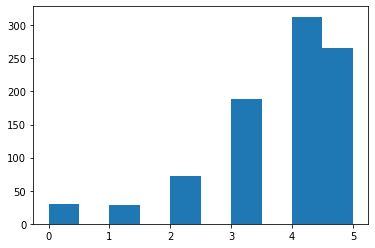

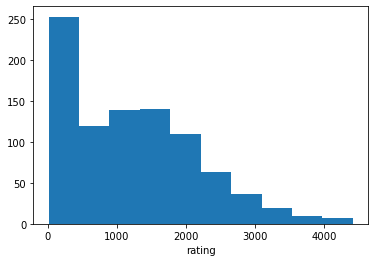

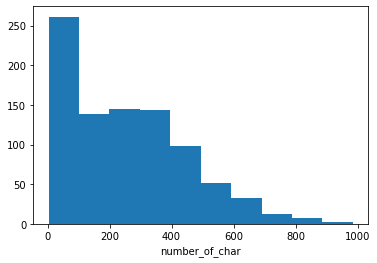

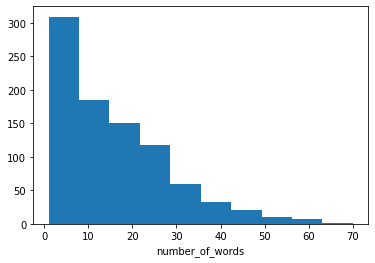

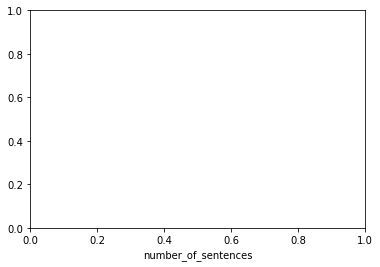

In [43]:
# Histogram
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(plt.hist(train[train.columns[i]]))
        plt.xlabel(train.columns[i])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


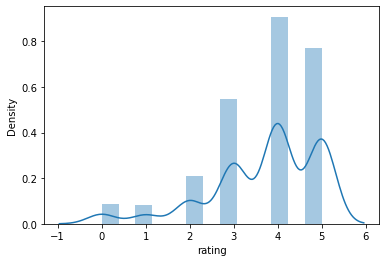

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


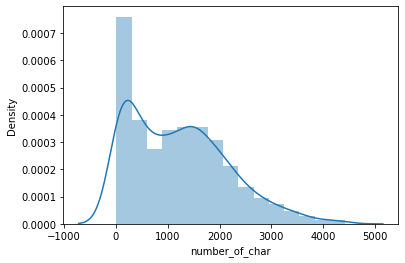

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


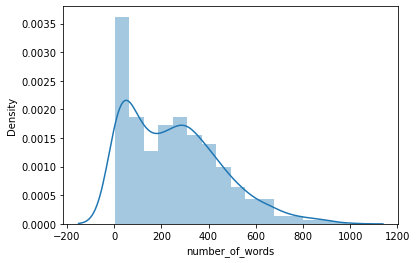

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


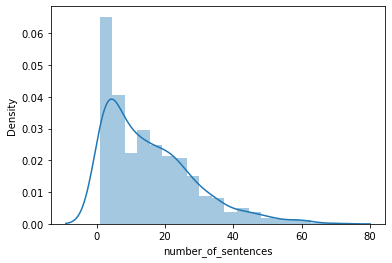

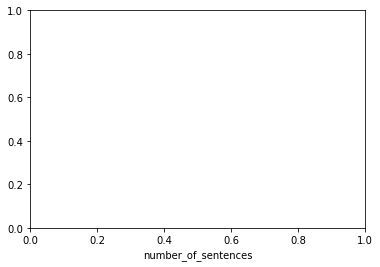

In [44]:
# Distplot
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(sns.distplot(train[train.columns[i]]))
        plt.xlabel(train.columns[i])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


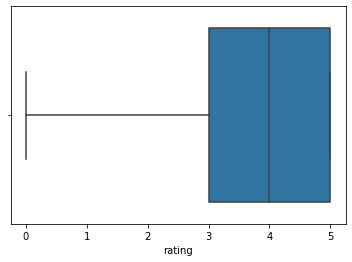

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


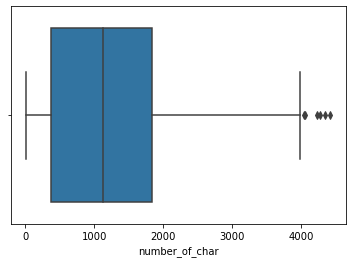

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


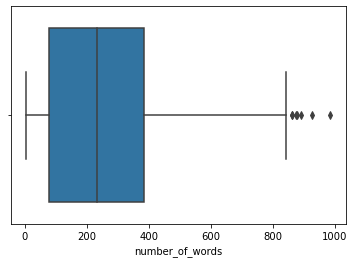

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


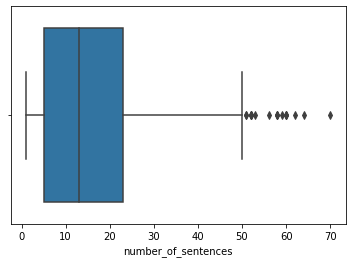

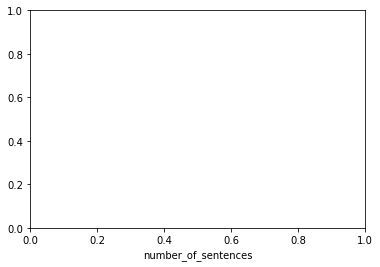

In [45]:
# BoxPlot
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(sns.boxplot(train[train.columns[i]]))
        plt.xlabel(train.columns[i])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


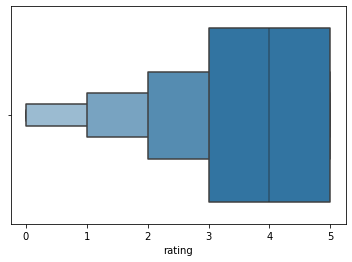

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


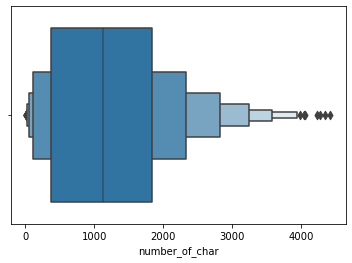

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


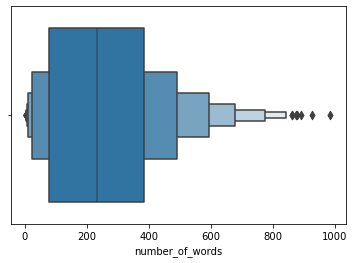

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


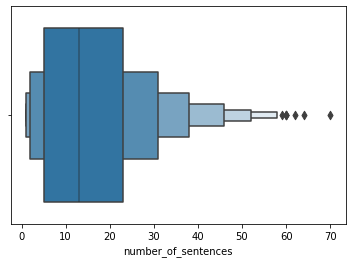

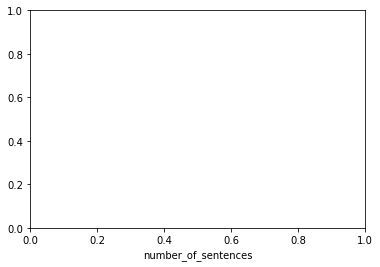

In [46]:
# BoxenPlot
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(sns.boxenplot(train[train.columns[i]]))
        plt.xlabel(train.columns[i])

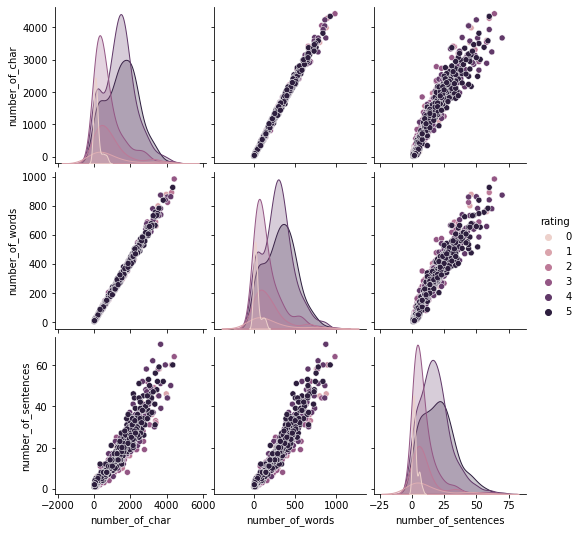

In [47]:
sns.pairplot(train, hue="rating")

In [48]:
train.corr()

,rating,number_of_char,number_of_words,number_of_sentences
rating,1.000000,0.347354,0.340915,0.355504
number_of_char,0.347354,1.000000,0.997545,0.948016
number_of_words,0.340915,0.997545,1.000000,0.958803
number_of_sentences,0.355504,0.948016,0.958803,1.000000


<AxesSubplot:>

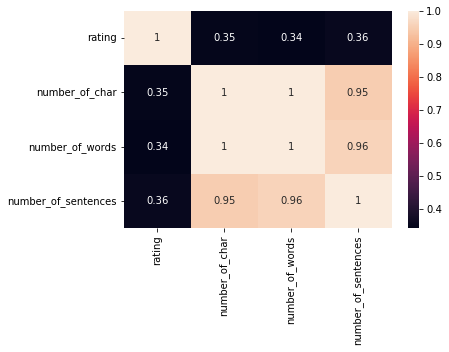

In [49]:
sns.heatmap(train.corr(), annot=True)

In [50]:
# Wordcloud for text visualization - most used words throughout all reviews

def show_wordcloud(data, title = None):
    # Initialize the wordcloud
    wordcloud = WordCloud(
        colormap            = "Spectral",
        scale               = 3,
        random_state        = 1
    ).generate(str(data))

    # Customize the wordcloud plot
    fig = plt.figure(1, figsize = (16, 16))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    # Plot and display the wordcloud
    plt.imshow(wordcloud)
    plt.show()

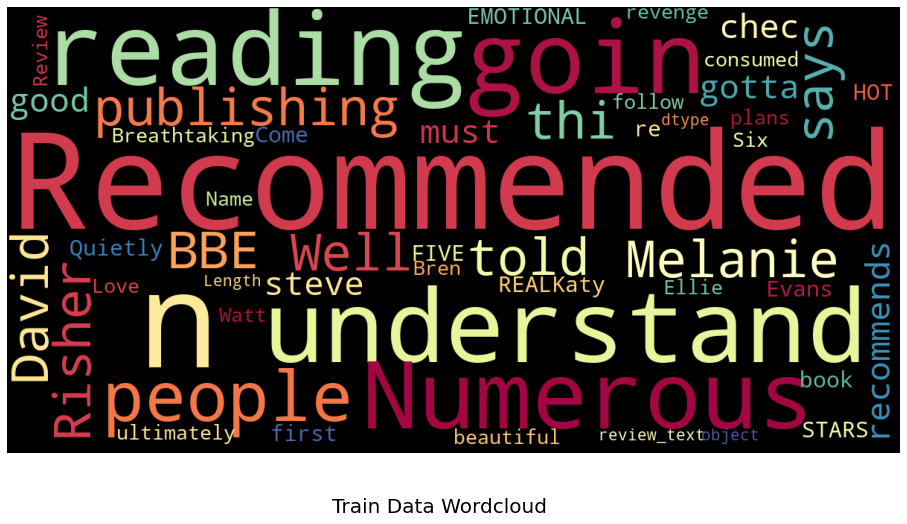

In [51]:
# Train data word cloud
show_wordcloud(train["review_text"], title = "Train Data Wordcloud")

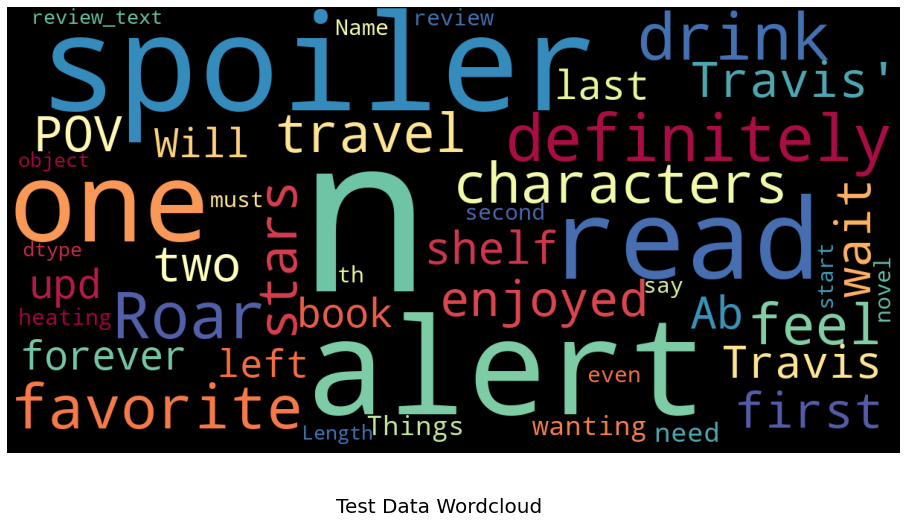

In [52]:
# Test data word cloud
show_wordcloud(test["review_text"], title = "Test Data Wordcloud")

# **Text Preprocessing**

In [53]:
#REMOVING LINKS, PUNCTUATIONS and CREATING TOKENS(TOKENISATION)

def preprocessing1(text):
    te = re.sub(r'http\S+', "", text)
    tokens = word_tokenize(te)
    
    punctuations = string.punctuation
    txt = []
    for i in tokens:
        if i not in punctuations:
            txt.append(i)
    return txt

In [54]:
train["review_text"] = train["review_text"].apply(preprocessing1)

In [55]:
train["review_text"][1]

['Recommended', 'by', 'Don', 'Katz', 'Avail', 'for', 'free', 'in', 'December']

In [56]:
#REMOVING STOPWORDS & CONVERTING TO LOWERCASE

def preprocessing2(text):
    stopword = stopwords.words("english")
    ntxt = []
    for j in text:
        if j not in stopword:
            ntxt.append(j.lower())
    return ntxt

In [57]:
train["review_text"] = train["review_text"].apply(preprocessing2)

In [58]:
train["review_text"][0]

['this',
 'special',
 'book',
 'it',
 'started',
 'slow',
 'first',
 'third',
 'middle',
 'third',
 'started',
 'get',
 'interesting',
 'last',
 'third',
 'blew',
 'mind',
 'this',
 'i',
 'love',
 'good',
 'science',
 'fiction',
 'pushes',
 'thinking',
 'things',
 'go',
 'it',
 '2015',
 'hugo',
 'winner',
 'translated',
 'original',
 'chinese',
 'made',
 'interesting',
 'different',
 'way',
 'things',
 'i',
 "'ve",
 'read',
 'for',
 'instance',
 'intermixing',
 'chinese',
 'revolutionary',
 'history',
 'kept',
 'accusing',
 'people',
 '``',
 'reactionaries',
 "''",
 'etc',
 'it',
 'book',
 'science',
 'aliens',
 'the',
 'science',
 'described',
 'book',
 'impressive',
 'book',
 'grounded',
 'physics',
 'pretty',
 'accurate',
 'far',
 'i',
 'could',
 'tell',
 'view',
 'spoiler',
 'though',
 'got',
 'folding',
 'protons',
 '8',
 'dimensions',
 'i',
 'think',
 'making',
 'stuff',
 'interesting',
 'think',
 'though',
 'but',
 'would',
 'happen',
 'seti',
 'stations',
 'received',
 'message

In [59]:
#STEMMING

def preprocessing3(text):
    stem = []
    Stemmer = PorterStemmer()
    for i in text:
        stem.append(Stemmer.stem(i))
    return " ".join(stem)

In [60]:
train["review_text"] = train["review_text"].apply(preprocessing3)

In [61]:
train["review_text"][0]

"thi special book it start slow first third middl third start get interest last third blew mind thi i love good scienc fiction push think thing go it 2015 hugo winner translat origin chines made interest differ way thing i 've read for instanc intermix chines revolutionari histori kept accus peopl `` reactionari '' etc it book scienc alien the scienc describ book impress book ground physic pretti accur far i could tell view spoiler though got fold proton 8 dimens i think make stuff interest think though but would happen seti station receiv messag found someon person monitor answer signal side disillus that part book bit dark i would like think human reaction discov alien civil hostil would like ender game would band togeth i like book unveil trisolaran cultur game it smart way build empathi also understand 've gone across mani centuri and know 3 bodi problem unsolv math problem but i still n't get made game mayb come next book i love quot `` in long histori scientif progress mani proto

In [62]:
test["review_text"][0]

'** spoiler alert ** \n This is definitely one of my favorites among the "food books" I\'ve read! I loved the characters (Raggedy Ann and Ken Carson included)! Even though Kayla is a pessimist (which I usually dislike in a character), her personality is the perfect formula in the story. \n Kayla is the school rebel, she wears unusual clothes, makes fun of the "popular" crowd in school, and she only have one friend in school---Nicole. Lately, things have been changing around her. Her mother barely talks to her and her best friend is dating her long-time crush Ben! On her disastrous 16th birthday party, she made a wish to make all her birthday wishes come true. The following day she wakes up with a pink pony on her backyard! The next day it was a room full of gumballs, and the next her Raggedy doll Ann was brought to life! She figured out that her birthday wishes are coming true and she have to find a way to stop it before her 15th birthday wish comes true---which is a kiss from Ben! \n 

In [63]:
# test["review_text"] = test["review_text"].apply(preprocessing1)
# test["review_text"] = test["review_text"].apply(preprocessing2)
# test["review_text"] = test["review_text"].apply(preprocessing3)

In [65]:
train.sample(10)

,review_text,rating,number_of_char,number_of_words,number_of_sentences
435,4.5 star i love pick book total surpris enthra...,4,2566,546,31
64,spoiler alert thi book may well call one hundr...,4,890,176,8
204,5 fight star `` i 'll fight us i 'll need figh...,5,2138,443,23
1357,i liter finish intens i n't readi level dark i...,3,227,54,5
58,if steve recommend must good,0,40,10,1
1292,listen audiobook,3,22,4,1
127,thi book start someth els turn adult erot expl...,4,2704,591,41
158,`` it 's never late chang road 're '' the syno...,4,1034,207,12
76,one top 5 favorit read deeper/figur life momen...,5,126,25,2
442,4.5 scorch star as someon read lot m/m book i ...,4,1310,263,16


# **MODEL BUILDING**

In [66]:
cv = CountVectorizer()
tfd = TfidfVectorizer(max_features=3000)

In [67]:
x = tfd.fit_transform(train["review_text"]).toarray()
y = train["rating"].values

In [68]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [70]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
pred = gnb.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

47.22222222222222
[[ 1  0  0  1  2  1]
 [ 0  0  0  0  1  0]
 [ 0  0  0  9  2  3]
 [ 0  5  1 13  9 10]
 [ 0  0  2  6 45 22]
 [ 1  1  0  3 16 26]]


In [71]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
pred = mnb.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

58.88888888888889
[[ 0  0  0  1  2  2]
 [ 0  0  0  1  0  0]
 [ 0  0  0  6  4  4]
 [ 0  0  0 14 16  8]
 [ 0  0  0  4 61 10]
 [ 0  0  0  1 15 31]]


In [72]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
pred = bnb.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

56.111111111111114
[[ 0  0  0  5  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0 14  0  0]
 [ 0  0  1 33  2  2]
 [ 0  0  3 16 38 18]
 [ 0  0  0 11  7 29]]


In [73]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [74]:
def model_training(model):
    model.fit(x_train, y_train) 
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
#     precision = precision_score(y_test, pred)
    
    return accuracy

In [75]:
model_training(xgb)

0.55

In [76]:
models = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [77]:
accuracy_scores = []

for name, model in models.items():
    
    current_accuracy = model_training(model)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy*100)
    print("====================================")
    
    accuracy_scores.append(current_accuracy)

For  SVC
Accuracy -  65.0
For  KN
Accuracy -  47.77777777777778
For  NB
Accuracy -  58.88888888888889
For  DT
Accuracy -  49.44444444444444
For  LR
Accuracy -  55.55555555555556
For  RF
Accuracy -  57.22222222222222
For  AdaBoost
Accuracy -  43.333333333333336
For  BgC
Accuracy -  55.00000000000001
For  ETC
Accuracy -  57.77777777777777
For  GBDT
Accuracy -  55.55555555555556
For  xgb
Accuracy -  55.00000000000001


In [78]:
model_performance = pd.DataFrame({'Models/Algorithms':models.keys(), 'Accuracy':accuracy_scores}).sort_values('Accuracy', ascending=False)
model_performance

,Models/Algorithms,Accuracy
0,SVC,0.650000
2,NB,0.588889
8,ETC,0.577778
5,RF,0.572222
4,LR,0.555556
9,GBDT,0.555556
7,BgC,0.550000
10,xgb,0.550000
3,DT,0.494444
1,KN,0.477778


In [79]:
# Voting Classifier 
# Selecting the three Classifiers which are better in case of Accuracy and Precision
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

voting = VotingClassifier(estimators=[('etc', etc), ('mnb', mnb), ('svc', svc)], voting='soft')
voting.fit(x_train, y_train)
pred = voting.predict(x_test)

print("Accuracy",accuracy_score(y_test, pred)*100)

Accuracy 65.0


In [80]:
# Applying stacking
# Selecting the three Classifiers which are better in case of Accuracy and Precision and Considering Final Estimator as RandomForestClassifier 

estimators=[('etc', etc), ('mnb', mnb), ('svc', svc)]
final_estimator=RandomForestClassifier()
stc = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stc.fit(x_train, y_train)
pred = stc.predict(x_test)

print("Accuracy",accuracy_score(y_test, pred)*100)

Accuracy 61.111111111111114


In [81]:
# Training Data Accuracy

pred = voting.predict(x_train)
accuracy_score(y_train, pred)*100      #Overfit

98.74301675977654

In [82]:
#CROSS VALIDATION TO CHECK WHETHER THE MODEL IS GENERALIZED OR NOT

voting_crossval = cross_val_score(VotingClassifier(estimators=[('etc', etc), ('mnb', mnb), ('svc', svc)], voting='soft'), x_train, y_train, cv=10)
print(voting_crossval)
print(np.round(np.mean(voting_crossval),2)*100)

[0.58333333 0.61111111 0.66666667 0.52777778 0.63888889 0.51388889
 0.57746479 0.6056338  0.66197183 0.5915493 ]
60.0


In [83]:
# test_trans = tfd.fit_transform(test["review_text"]).toarray()
# test_pred = voting.predict(test_trans)